# Boosting

*Boosting* de bagging gibi bir çok modeli bir arada kullanarak bir sonucun uretildigi baska bir *ensemble* teknigidir.

Bagging'in aksine, *boosting* tekniginde uretilen modeller birbirinden bagimsiz degildir.

> Her bir model, kendinden onceki modellerin hatalarini duzeltmek uzere uretilir.
>
> Buna gore, *boosting*de kullanilan modellerin kompleks olmaktan uzak, genel modeller olmasi gerekir. (Hata olmazsa duzeltme yapacak sonraki modellere ihtiyac olmazdi.)


Asagida iki ayri *boosting* teknigini gorecegiz:

- **Adaptive Boosting (ADAboost)**
- **Gradient Boosting (GB)**

In [1]:
from sklearn import datasets, tree, ensemble, metrics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import warnings

In [2]:
X, y = datasets.make_classification(
    n_samples=35, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_repeated=0, 
    n_classes=2, 
    n_clusters_per_class=1, 
    weights=None, 
    flip_y=0.0, 
    class_sep=0.8, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=27)

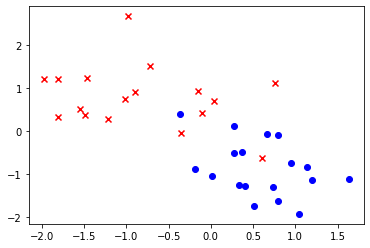

In [3]:
plt.scatter(*X[y==1].T, color='r', marker='x')
plt.scatter(*X[y==0].T, color='b', marker='o');

In [4]:
xx, yy = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))

# Adaptive Boosting (ADABoost)

## Egitim

*ADABoost* tekniginde, genellikle karar kutukleri (decision stumps) kullanilir.

0. Tum ornekler esit agirliga sahiptir.
1. Zayif model egitim verisi uzerinde egitilir.
2. Her bir ornek icin yapilan hata hesaplanir.
3. **Modelin genel hatasi kullanilarak modele bir agirlik atanir.**
4. **Her bir ornegin hatasi kullanilarak, orneklerin egitimdeki agirliklarina duzeltme uygulanir.**
5. Orneklerin yeni agirliklari kullanilarak yeni bir model tekrar uretilir.
    - Yeni model, agirligi daha yuksek olan ornekleri daha dogru tahmin etmek uzere hareket edecektir.
6. `2`, `3`, `4` ve `5.` adimlar tekrarlanir.

### Hatanin hesaplanmasi

Bir ornegin $t$'inci iterasyonda agirliginin $D_t(i)$ oldugunu varsayalim.


Buna gore $t$'inci iterasyonda egitilen ogrenicinin hata orani:

$$ \epsilon_t =  \frac{\sum_{i=1}^{N}{D_t(i) \bm{I}[y_i \ne G_t(X_i)]}}{\sum_{i=1}^{N}{D_t(i)}}$$

Yukaridaki islem kisaca; her bir hatayi ornek agirliklariyla carpip normalize etmeye karsilik gelmektedir.

$\bm{I}[y_i \ne G_t(X_i)]$ terimi, eger yapilan tahmin ile gercek sinif uyusuyorsa 0, uyusmuyorsa 1 degerini verir.

### Ogrenici katsayisinin hesaplanmasi

Yukarida hesapladigimiz hata oranini kullanarak, ogreniciye bir katsayi atayabiliriz:

$$ \alpha_t = \gamma_0 \ln{\frac{1 - \epsilon_t}{\epsilon_t}} $$

$\gamma_0$ terimi, ogrenme orani olup basta belirnenen sabit bir degerdir.

Burada onemli husus, zayif ogrenicinin basari oraninin $0.5$'den daha buyuk olmasi ihtiyacidir (yani hata orani $0.5$'den kucuk olmali).

### Ornek agirliklarinin guncellenmesi: *SAMME algoritmasi*


Ornek olarak, *SAMME* algoritmasindaki ornek agirligi guncellemesi su sekilde olmaktadir:

$$ D_{t+1}(i)  = { D_t(i) e^{-\alpha_t Y_i \bm{I[y_i \ne G_t(X_i)]}} }$$

Muteakiben, isterseniz agirliklari normalize edebilirsiniz.

### Tahmin

Egitmis oldugumuz boosting algoritmasinin tahmini, tum zayif ogrenicilerin tahminlerinin bir lineer kombinasyonu olarak bulunur:

$$ \hat{y_i} = sgn{[\sum_{t=1}^{m}{\alpha_t G_t(X_i)}]} $$

In [5]:
class IncelenebilirAdaBooster(ensemble.AdaBoostClassifier):
    def _boost(self, iboost, X, y, sample_weight, random_state):
        args = super()._boost(iboost, X, y, sample_weight, random_state)
        self.last_weights_ = args[0]
        return args

In [6]:
@interact
def lrviz(learning_rate=(-3,3,1)):
    @interact(n_iters=(1,100,1))
    def boostviz(n_iters=1):
        model = IncelenebilirAdaBooster(
            base_estimator=tree.DecisionTreeClassifier(max_depth=1),
            n_estimators=n_iters,
            learning_rate=10**learning_rate,
            algorithm='SAMME.R',
            random_state=None,
            )
        plt.figure(figsize=(18,6))
        with warnings.catch_warnings():
            warnings.simplefilter('error')
            try:
                model.fit(X, y)
            except RuntimeWarning as e:
                plt.scatter(*X[y==1].T, color='r', marker='x')
                plt.scatter(*X[y==0].T, color='b', marker='o');                
                plt.text(-2, 0, "W A S T E D" , fontsize=156, color='red')
                plt.title(f"{e}: Ornek agirliklari asiri artti.")
                return

        zz = np.array(list(model.staged_decision_function(np.c_[xx.ravel(), yy.ravel()])))
        ax = plt.subplot(1, 3, 1)
        plt.contourf(xx, yy, zz[n_iters-1].reshape(xx.shape), cmap=plt.cm.PuBu)
        plt.colorbar().set_label('$\mathbf{f(x)}$')
        plt.scatter(*X[y==1].T, color='r', marker='x')
        plt.scatter(*X[y==0].T, color='b', marker='o');
        plt.title('Boosting karar fonksiyonu')

        plt.subplot(1, 3, 2, sharey=ax)
        plt.title('Ornek agirliklari')
        plt.scatter(X[:, 0], X[:, 1], c=model.last_weights_)
        plt.colorbar().set_label('$\mathbf{w}$')

        plt.subplot(1, 3, 3, sharey=ax)
        plt.contourf(xx, yy, model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape), cmap=plt.cm.PuBu)
        plt.colorbar().set_label('$\mathbf{\hat{y}}$')
        plt.scatter(X[:, 0], X[:, 1], c=y)
        plt.title('Boosting karar sinirlari')
        plt.suptitle('AdaBoost karar sinirlari - LR = $10^{}$'.format(learning_rate))


    

interactive(children=(IntSlider(value=0, description='learning_rate', max=3, min=-3), Output()), _dom_classes=…

# Gradient Boosting (GB)

Adaptive boosting, gercekte GB'nin ozel bir durumu, diger bir deyisle GB, adaptive boosting'in bir genellemesidir.

Her bir iterasyonda, bir onceki ogrenicinin hatasini kapatacak bir tahminleme yapmaya dayali sistemimizi biraz daha farkli bir sekilde uygulayacagiz.

$$ F_{t+1}(X_i) = F_t(X_i) + \gamma $$

Asagida karar agaclari ile uygulanan GB icin bir pseudokod bulunmaktadir:


0. Sabit bir tahmin ile basla: $F_0(x) = a$
1. Her bir ornek icin hatalari hesapla
2. Orneklerin hatalarina en iyi uyum saglayacak agaci egit.
3. Agacin her yapragindaki ornek icin, onceki karar fonksiyonunun uzerine hatayi kucultecek bir miktar ekle.
4. `1`, `2` ve `3` nolu adimlari tekrar et.


Gradient Boosting ornegini, daha anlasilabilir olmasi acisindan regresyon ile yapalim:

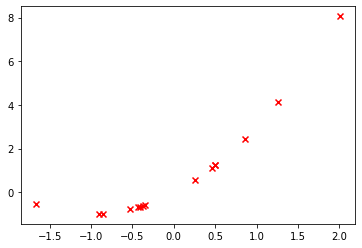

In [7]:
np.random.seed(43)
X1 = np.random.randn(15, 1)

forig = lambda x: x**2 + 2*x

y1 = forig(X1).ravel()
plt.scatter(X1, y1, color='r', marker='x');

### Baslangic

Sabit bir deger ile tahminlerimizi baslatiriz. 

Regresyon icin bu sabit tahmin $\bar{y}$ olabilir.

In [8]:
from sklearn import dummy

In [9]:
d = dummy.DummyRegressor(strategy='mean')
d.fit(X1, y1)
d.predict(X1)

array([0.86465924, 0.86465924, 0.86465924, 0.86465924, 0.86465924,
       0.86465924, 0.86465924, 0.86465924, 0.86465924, 0.86465924,
       0.86465924, 0.86465924, 0.86465924, 0.86465924, 0.86465924])

In [10]:
def f0(x):
    return d.predict(x)

### Hatalar

In [11]:
p_residuals = y1 - d.predict(X1)

### Hatalara uyum saglayan agac

In [12]:
t1 = tree.DecisionTreeRegressor(max_depth=1)
t1.fit(X1, p_residuals)

DecisionTreeRegressor(max_depth=1)

### Hatalari kuculten miktar

Hatalari minimize eden sabit sayi, MSE icin her yaprakta kalan hatanin ortalamalari olacaktir.

**Bu duruma ozel olarak** agacimizin ogrendigi degerleri dogrudan tahmin icin kullanabiliriz.

### Yeni tahmin fonksiyonu

Yeni tahmin fonksiyonumuz su sekilde olacaktir:

$$ F_{t+1}(X) = F_t(X) + \alpha h_{t+1}(X) $$


Buradaki $\alpha$ ogrenme ornai olup, *gradient descent*'e benzer bir fonksiyon ustlenecektir.

In [13]:
alpha = 0.1

In [14]:
def f1(x):
    return d.predict(x) + alpha * t1.predict(x)

### Tekrar hatalar...

In [15]:
p_residuals = y1 - f1(X1)

### Tekrar egitim ...

In [16]:
t2 = tree.DecisionTreeRegressor(max_depth=1)
t2.fit(X1, p_residuals)

def f2(x):
    return f1(x) + alpha * t2.predict(x)

<AxesSubplot:xlabel='x'>

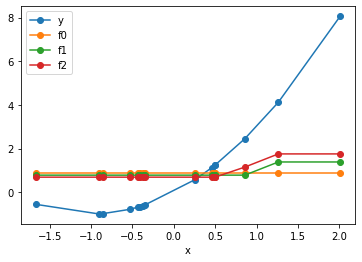

In [17]:
pd.DataFrame().assign(y=y1).assign(f0=f0(X1)).assign(f1=f1(X1)).assign(f2=f2(X1)).assign(x=X1[:, 0]).sort_values('x').plot(x='x', y=['y', 'f0', 'f1', 'f2'], marker='o')

Asagida bu islemi iterasyonlar boyunca interaktif olarak yaparak sonucun gelisimini gozlemleyelim:

In [18]:
@interact(alpha=(0.1,1,0.1), max_depth=(1,8,1))
def aviz(alpha=0.1, max_depth=1):
    @interact(iters=(0,100,1))
    def gbregviz(iters=0):
        d = dummy.DummyRegressor(strategy='mean')
        d.fit(X1, y1)
        agaclar = [d]

        def f(x):
            p = d.predict(x)
            for agac in agaclar:
                p += alpha * agac.predict(x)
            return p


        for i in range(1, iters+1):
            r = y1 - f(X1)
            t = tree.DecisionTreeRegressor(max_depth=max_depth)
            t.fit(X1, r)
            agaclar.append(t)
        rng = np.linspace(-3, 3, 100)

        plt.plot(rng, forig(rng), color='g', linestyle='dashed', label='Gercek fonksiyon')
        plt.plot(rng, f(rng[:, None]), color='r', label='Boosting ciktisi')
        plt.scatter(X1, y1, color='b', marker='x', label='Ornekler')
        plt.legend()

interactive(children=(FloatSlider(value=0.1, description='alpha', max=1.0, min=0.1), IntSlider(value=1, descri…

## Gradient descent ile karsilastirma

In [20]:
from sklearn import linear_model, pipeline, preprocessing
from ipywidgets import FloatLogSlider
@interact(alpha=FloatLogSlider(min=-10, max=0, value=0, step=0.1, description='alpha', base=2))
def lrviz(alpha=1./64.):
    @interact(iters=(0,100,1))
    def gdviz(iters=0):
        p = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
        model = linear_model.SGDRegressor(loss='squared_error', penalty='l2', max_iter=1, tol=1e-3, shuffle=True, random_state=None, eta0=alpha, validation_fraction=1e-5)
        xp = p.fit_transform(X1)
        model._check_n_features(xp.shape[1], True)
        model.coef_ = np.zeros(xp.shape[1])
        model.intercept_ = np.array([0.0])
        for i in range(iters):
            model.partial_fit(xp, y1, )
        t = np.linspace(-3, 3, 100)
        plt.plot(t, forig(t), color='g', linestyle='dashed', label='Gercek fonksiyon')
        plt.plot(t, model.predict(p.transform(t[:, None])), color='r', label='Gradient Descent')
        plt.scatter(X1, y1, color='b', marker='x', label='Ornekler')
        plt.legend()
        plt.title(f"{iters} iterasyon sonunda karar fonksiyonu")


interactive(children=(FloatLogSlider(value=0.0009765625, base=2.0, description='alpha', max=0.0, min=-10.0), O…

## Tasniflendirme icin boosting

In [19]:
@interact(learning_rate=(-3.,3.,.1))
def gbviz(learning_rate=0):
    @interact(n_iters=(1,100,1))
    def boostviz(n_iters=1):
        model = ensemble.GradientBoostingClassifier(
            n_estimators=n_iters,
            learning_rate=10**learning_rate,
            max_depth=1,
            random_state=None,
            )
        plt.figure(figsize=(18,6))

        model.fit(X, y)


        zz = np.array(list(model.staged_decision_function(np.c_[xx.ravel(), yy.ravel()])))

        ax = plt.subplot(1, 4, 1)
        plt.contourf(xx, yy, zz[n_iters-1].reshape(xx.shape), cmap=plt.cm.PuBu)
        plt.colorbar().set_label('$\mathbf{f(x)}$')
        plt.scatter(*X[y==1].T, color='r', marker='x')
        plt.scatter(*X[y==0].T, color='b', marker='o');
        plt.title('Boosting karar fonksiyonu')

        plt.subplot(1, 4, 2, sharey=ax)
        plt.title('Ornek gradyanlari')
        plt.scatter(X[:, 0], X[:, 1], c=model.loss_.negative_gradient(y, model.decision_function(X),))
        plt.colorbar().set_label('$\mathbf{w}$')

        plt.subplot(1, 4, 3, sharey=ax)
        plt.contourf(xx, yy, model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape), cmap=plt.cm.PuBu)
        plt.scatter(*X[y==1].T, color='r', marker='x')
        plt.scatter(*X[y==0].T, color='b', marker='o');
        plt.title('Karar sinirlari')

        plt.suptitle('GradientBoost karar sinirlari - LR = $10^{{{}}}$'.format(learning_rate))

        plt.subplot(1, 4, 4)
        accuracy = [metrics.log_loss(y, i) for i in model.staged_decision_function(X)]
        plt.plot(accuracy, marker='o')
        plt.semilogy()
        plt.grid()
        plt.xlabel('Iterasyon')
        plt.ylabel('Logloss')
        plt.title('Kayip')



interactive(children=(FloatSlider(value=0.0, description='learning_rate', max=3.0, min=-3.0), Output()), _dom_…